In [5]:
import tensorflow as tf
import numpy as np
from utils.config import Config
from utils.data import Dataset
from model.fasterrcnn import FasterRCNNTrainer, FasterRCNN
from model.rpn import RegionProposalNetwork
from model.roi import RoIHead
from utils.anchor import loc2bbox, AnchorTargetCreator, ProposalTargetCreator

In [13]:
import matplotlib.pyplot as plt

In [14]:
%matplotlib notebook

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
from utils.data import VOC_BBOX_LABEL_NAMES

In [2]:
def _smooth_l1_loss(pred_loc, gt_loc, in_weight):
    # pred_loc, gt_loc, in_weight
    x = tf.reshape(pred_loc, [-1, 4])
    diff = in_weight * (x - gt_loc)
    abs_diff = tf.math.abs(diff)
    flag = tf.cast(abs_diff.numpy() < 1., dtype=tf.float32)
    y = (flag * (0.5) * (diff ** 2) + (1 - flag) * (abs_diff - 0.5))
    return tf.reduce_sum(y)


def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label):
    """
    :param pred_loc: 1,38,50,36
    :param gt_loc: 17100,4
    :param gt_label: 17100
    """
    in_weight = np.zeros(gt_loc.shape)
    idx = (gt_label > 0).reshape([-1, 1])
    idx = np.stack([idx, idx, idx, idx], axis=1)
    idx = np.reshape(idx, in_weight.shape)
    in_weight[idx] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum())  # ignore gt_label==-1 for rpn_loss
    return loc_loss

In [8]:
config = Config()
config._parse({})
dataset = Dataset(config)
frcnn = FasterRCNN(21, (7, 7))
model = FasterRCNNTrainer(frcnn)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
# 相当于build一下模型
img, bbox, label = dataset[1]
x = tf.convert_to_tensor(img, dtype=tf.float32)
x = tf.expand_dims(x, axis=0)
_, _, _, _ = model(x, bbox, label)
# 然后就能载入权重了
model.load_weights('frcnn.h5')

======user config========
{'max_size': 1000,
 'min_size': 600,
 'voc_data_dir': 'D:/DataClinic/simple-faster-rcnn-pytorch/VOCdevkit/VOC2007/'}
==========end============


In [16]:
img, bbox, label = dataset[1]
x = tf.convert_to_tensor(img, dtype=tf.float32)
x = tf.expand_dims(x, axis=0)

In [17]:
img = (img + 1) / 2.

In [49]:
img_size = img.shape[:2]

<IPython.core.display.Javascript object>


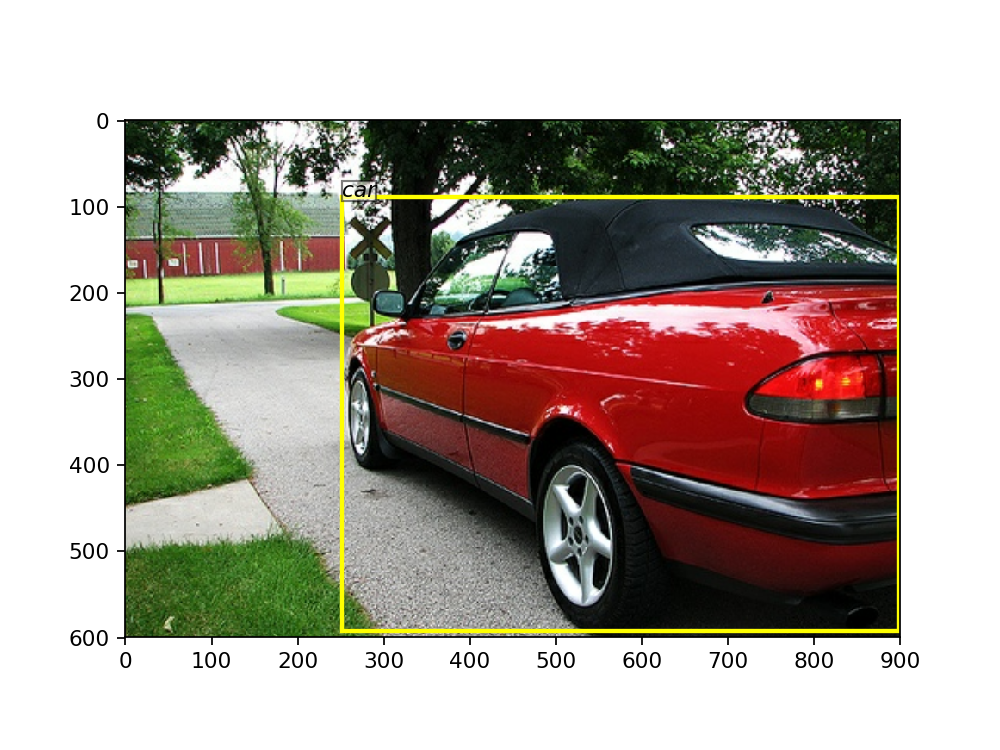

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

for i in range(len(bbox)):
    y1 = bbox[i][0]
    x1 = bbox[i][1]
    y2 = bbox[i][2]
    x2 = bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[label[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

In [20]:
feature_map, rpn_loc, rpn_score, roi, anchor = model.faster_rcnn.rpn(x)

In [21]:
for x in (feature_map, rpn_loc, rpn_score, roi, anchor):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (1, 38, 57, 512) max: 0.0 min: 0.0
shape: (1, 38, 57, 36) max: 0.28400645 min: -0.84655166
shape: (1, 19494, 2) max: 0.9067492 min: 0.09325082
shape: (1678, 4) max: 900.0 min: 0.0
shape: (19494, 4) max: 1266.0387 min: -354.03867


In [53]:
sample_roi, gt_roi_loc, gt_roi_label, keep_index = model.proposal_target_creator(roi, bbox, label)

In [54]:
roi_cls_loc, roi_score = model.faster_rcnn.head(feature_map, sample_roi, img_size)

In [55]:
for x in (roi_cls_loc, roi_score):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (128, 84) max: 0.35054564 min: -0.31283775
shape: (128, 21) max: -0.4731195 min: -2.7144854


In [56]:
n_sample = roi_cls_loc.shape[0]
n_sample

128

In [69]:
roi_cls_loc = tf.reshape(roi_cls_loc, [n_sample, -1, 4])
roi_cls_loc

<tf.Tensor: shape=(128, 21, 4), dtype=float32, numpy=
array([[[ 0.00347915,  0.00063556, -0.02472206, -0.02540891],
        [-0.06602678, -0.05372782, -0.1856401 ,  0.14664312],
        [-0.0257837 , -0.00378731, -0.01883769,  0.1999844 ],
        ...,
        [-0.10122371, -0.05987186, -0.31283775,  0.0046657 ],
        [-0.01752823, -0.04704198, -0.1182461 ,  0.17051129],
        [ 0.00854266,  0.01821543, -0.19528075, -0.11754191]],

       [[ 0.00347915,  0.00063556, -0.02472206, -0.02540891],
        [-0.06602678, -0.05372782, -0.1856401 ,  0.14664312],
        [-0.0257837 , -0.00378731, -0.01883769,  0.1999844 ],
        ...,
        [-0.10122371, -0.05987186, -0.31283775,  0.0046657 ],
        [-0.01752823, -0.04704198, -0.1182461 ,  0.17051129],
        [ 0.00854266,  0.01821543, -0.19528075, -0.11754191]],

       [[ 0.00347915,  0.00063556, -0.02472206, -0.02540891],
        [-0.06602678, -0.05372782, -0.1856401 ,  0.14664312],
        [-0.0257837 , -0.00378731, -0.01883769, 

In [71]:
tf.range(0, n_sample)

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])>

In [72]:
gt_roi_label

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
idx_ = [[i, j] for i, j in zip(range(n_sample), gt_roi_label)]
roi_loc = tf.gather_nd(roi_cls_loc, idx_)

In [79]:
roi_loc_loss = _fast_rcnn_loc_loss(roi_loc, gt_roi_loc, gt_roi_label)
roi_cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(gt_roi_label, roi_score)